In [1]:
import open3d as o3d
import volpy as vp

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import griddata

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Модель 1

Загрузим данные

In [2]:
FILEPATH = '1/DEM.xyz'
pcd = o3d.io.read_point_cloud(FILEPATH)
print(pcd)

PointCloud with 12918781 points.


Можно посмотреть на то, как выглядит модель в 3D:

In [3]:
axes = o3d.geometry.TriangleMesh.create_coordinate_frame(size=10)
o3d.visualization.draw_geometries([pcd, axes])

![3D model with axes](images/task1_3D_with_axes.png)

Или на карту высотности (downsampling сделан, чтобы точек стало меньше и график прогрузился)

<AxesSubplot:xlabel='x', ylabel='y'>

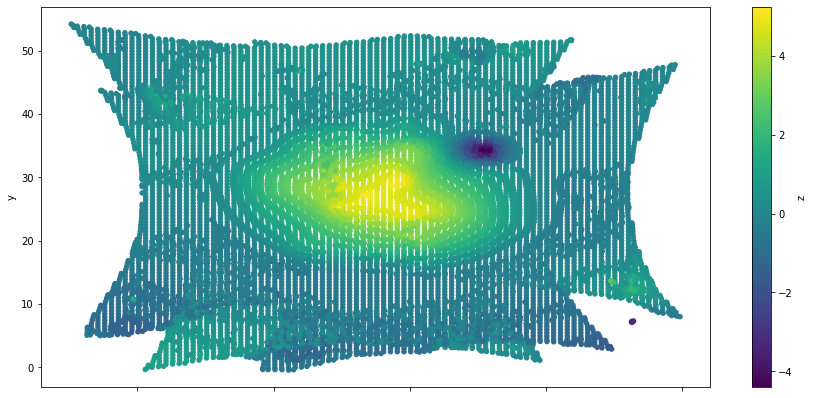

In [4]:
voxel_pcd = pcd.voxel_down_sample(voxel_size=0.5)
voxels = np.asarray(voxel_pcd.points)
voxels_df = pd.DataFrame(voxels, columns=['x','y','z'])
voxels_df.plot.scatter('x', 'y', c='z', colormap='viridis', figsize=(15,7))

Видим углубление и участки-выбросы, от которых желательно избавиться

Для начала определим, где находится пол. Если бы у всех 3х моделей пол располагался примерно параллельно Oxy, можно было бы грубо оценить уровень, взяв медиану. Но в случае если горка занимает большую часть модели, нет углублений, и при этом высота растет не быстро, при использовании медианы может быть потеряна существенная часть объема. Также в общем случае при случайных углублениях и неоднородной структуре горки в принципе подобрать уровень эвристикой становится неосуществимо, поэтому оптимальным решением будет сегментация плоскости, содержащей пол.

In [2]:
def separate_floor(pcd, distance_threshold):
    plane_model, inliers = pcd.segment_plane(distance_threshold=distance_threshold,
                                             # нужен минимальный порог, который позволит отделить горку от окружения
                                             # для дальнейшей кластеризации, но сохранит как можно больше чистой высоты горки
                                             ransac_n=3,
                                             num_iterations=100)
    floor = pcd.select_by_index(inliers)
    not_floor = pcd.select_by_index(inliers, invert=True)
    return floor, not_floor, plane_model

In [3]:
floor, not_floor, plane_model = separate_floor(pcd, distance_threshold=0.21)

Повернем модель так, чтобы пол стал параллелен Oxy

In [3]:
def rotation_matrix(new_z_axis):
    [a, b, c] = new_z_axis
    
    cos_theta = c / np.sqrt(a**2 + b**2 + c**2)
    sin_theta = np.sqrt((a**2+b**2)/(a**2 + b**2 + c**2))
    u_1 = b / np.sqrt(a**2 + b**2 )
    u_2 = -a / np.sqrt(a**2 + b**2)
    return np.array([[cos_theta + u_1**2 * (1-cos_theta), u_1*u_2*(1-cos_theta), u_2*sin_theta],
                            [u_1*u_2*(1-cos_theta), cos_theta + u_2**2*(1- cos_theta), -u_1*sin_theta],
                            [-u_2*sin_theta, u_1*sin_theta, cos_theta]])

In [5]:
matrix = rotation_matrix(plane_model[:3])
floor.rotate(matrix)
not_floor.rotate(matrix)

PointCloud with 6746491 points.

In [6]:
floor.paint_uniform_color([1.0, 0, 0])
not_floor.paint_uniform_color([0, 0, 1.0])
axes = o3d.geometry.TriangleMesh.create_coordinate_frame(size=10)
o3d.visualization.draw_geometries([floor, not_floor, axes])

![segmentation](images/task1_segmentation.png)

Если горка оказалась повернута вниз, отзеркалим модель (определяется глазами или исходя из того, что точка, наиболее удаленная от пола, принадлежит горке). Также сдвинем пол в центр координат и избавимся от всего, что ниже.

In [7]:
not_floor_points = np.asarray(not_floor.points)

peak_candidate_above = not_floor_points[:,2].max()
peak_candidate_below = not_floor_points[:,2].min()
floor_level =  floor.get_center()[2]

if peak_candidate_above - floor_level > floor_level - peak_candidate_below:
    not_floor_points = not_floor_points[not_floor_points[:,2] > floor_level]
    not_floor_points[:,2] -= not_floor_points[:,2].min()
else:
    not_floor_points = not_floor_points[not_floor_points[:,2] < floor.get_center()[2]]
    not_floor_points[:,2] *= -1
    not_floor_points[:,2] -= not_floor_points[:,2].min()

In [8]:
above_floor_pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(not_floor_points))
o3d.visualization.draw_geometries([above_floor_pcd])

![above floor](images/task1_above_floor.png)

Выделим горку с помощью кластеризации. Точки горки объединены тем, что находятся близко друг к другу, при этом во всех кластерах примерно одинаковая плотность, поэтому подойдет dbscan без улучшений (*eps* подбирал на глаз).

In [9]:
labels = np.array(above_floor_pcd.cluster_dbscan(eps=0.05, min_points=10, print_progress=True))
max_label = labels.max()
colors = plt.get_cmap("tab20")(labels / (max_label 
if max_label > 0 else 1))
colors[labels < 0] = 0
above_floor_pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([above_floor_pcd])

![clusters](images/task1_clusters.png)

In [10]:
stockpile_cluster = pd.Series(labels).mode()[0]

In [11]:
stockpile = np.asarray(above_floor_pcd.points)[labels == stockpile_cluster]
stockpile_pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(stockpile))
o3d.visualization.draw_geometries([stockpile_pcd])

In [122]:
stockpile_pcd

PointCloud with 3205631 points.

![stockpile](images/task1_stockpile.png)

Объем попробуем вычислить двумя способами:
1) по воксельной решетке (суммируем ${площадь \ клетки}*{среднее \ высот \ в \ вершинах \ клетки}$, где высоты получим интерполяцией)  
2) с помощью volpy

Считаем по вокселям:

Сначала построим решетку основания горки с помощью вокселизации `open3d`

In [13]:
VOXEL_SIZE = 0.05
stockpile_base_points = np.asarray(stockpile_pcd.points).copy()
stockpile_base_points[:,2] = 0
stockpile_base_pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(stockpile_base_points))
stockpile_base_voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(stockpile_base_pcd, voxel_size=VOXEL_SIZE)

Дальше найдем центры клеток и точки в углах

In [14]:
stockpile_base_voxel_grid_centers = np.asarray([
    stockpile_base_voxel_grid.origin + voxel.grid_index*VOXEL_SIZE
    for voxel in stockpile_base_voxel_grid.get_voxels()
])[:,:2]

In [15]:
grids_bases = 0.5 * VOXEL_SIZE * np.array([
    [-1, 1], [1, 1],
    [-1, -1], [1, -1]
])

grids = grids_bases + stockpile_base_voxel_grid_centers[:,None]

In [16]:
grids.shape

(178613, 4, 2)

Сделаем линейную интерполяцию (поскольку много точек находятся на расстоянии меньше вокселя, польза от более точных методов просто закроется ошибкой, накопленной на предыдущих шагах)

In [17]:
interpolation = griddata(stockpile[:,:2], stockpile[:,2], grids, method='linear')

Пропуски (точки, оказавшиеся снаружи горки) делаем нулем, потому что по преедположению они принадлежат полу, и высота там нулевая

In [114]:
interpolation = np.nan_to_num(interpolation, nan=0)

Осталось посчитать

In [18]:
(VOXEL_SIZE**2 * (interpolation[:,0] + interpolation[:,1] + interpolation[:,2] + interpolation[:,3])/4).sum()

868.6821135889686

Можно проверить, оценив порядок на глаз

In [20]:
pd.DataFrame(stockpile).describe()

,0,1,2
count,3.121198e+06,3.121198e+06,3.121198e+06
mean,1.785166e+01,2.677088e+01,1.954773e+00
std,5.936226e+00,6.159314e+00,1.403771e+00
min,6.072900e+00,1.488593e+01,5.513160e-03
25%,1.308524e+01,2.180978e+01,7.182441e-01
50%,1.781291e+01,2.660859e+01,1.742999e+00
75%,2.234133e+01,3.136658e+01,3.036646e+00
max,3.015930e+01,4.057504e+01,5.141901e+00


Амплитуда по х около 24, по у около 38, высота примерно 5, где-то 2/3 прямоугольника в основании заняты горкой, и можно оценить по формуле объема пирамиды

In [21]:
(30-6)*(40-1.5)*5*(2/3)*(1/3)

1026.6666666666665

Теперь сделаем downsampling для работы с volpy:  
триангуляция, которая осуществляется в volpy для поиска объема, выдает не watertight mesh при достаточно большом количестве неоднородно расположенных точек, такая же ситуация с аналогом у open3d, поэтому лучше взять большой размер клетки для downsampling, чтобы не прогадать (volpy вообще не предупреждает о возможном подвохе, из-за чего я несколько раз получал числа порядка $10^{15}$)

<AxesSubplot:xlabel='x', ylabel='y'>

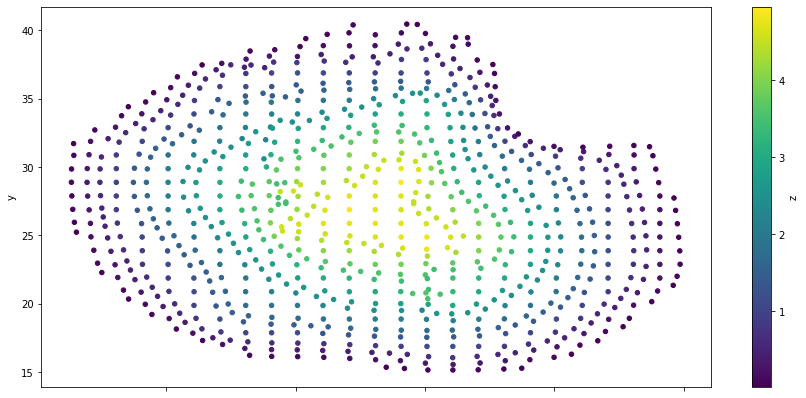

In [23]:
voxels_for_volpy = stockpile_pcd.voxel_down_sample(voxel_size=1)
voxels_for_volpy = np.asarray(voxels_for_volpy.points)
voxels_for_volpy = pd.DataFrame(voxels_for_volpy, columns=['x','y','z'])
voxels_for_volpy.plot.scatter('x', 'y', c='z', colormap='viridis', figsize=(15,7))

In [24]:
voxels_for_volpy.to_csv('voxels_for_volpy.csv', index=False)
survey = vp.load_survey('voxels_for_volpy.csv')
mesh = vp.terrain_mesh(survey.data)
mesh.get_volume()

Progress: |██████████████████████████████████████████████████| 100.0% Complete


861.731182735522

По воксельной решетке получили 869, так что истинный объем горки вероятно в районе 900  
При этом погрешность, которую получили на этапе сегментации пола, можно грубо сверху оценить как максимальная упущенная высота горки ($2 * пороговое \ значение$), умноженная на площадь основания ($количество \ вокселей \ в \ основании * площадь \ стороны \ вокселя$) 

In [28]:
2*0.21 * len(stockpile_base_voxel_grid_centers)*VOXEL_SIZE**2

187.54365

Так что грубо верхнюю границу ошибки можно оценить как $\approx20 \%$

Теперь проделаем ту же работу с моделями 2 и 3

# Модель 2

In [6]:
FILEPATH = '2/DEM.xyz'
pcd = o3d.io.read_point_cloud(FILEPATH)
print(pcd)

PointCloud with 13189200 points.


In [6]:
axes = o3d.geometry.TriangleMesh.create_coordinate_frame(size=10)
o3d.visualization.draw_geometries([pcd])

![3D model with axes](images/task2_3D_with_axes.png)

<AxesSubplot:xlabel='x', ylabel='y'>

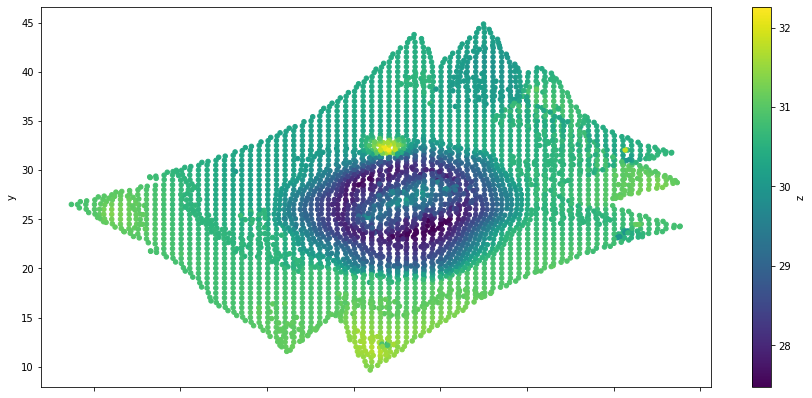

In [7]:
voxel_pcd = pcd.voxel_down_sample(voxel_size=0.5)
voxels = np.asarray(voxel_pcd.points)
voxels_df = pd.DataFrame(voxels, columns=['x','y','z'])
voxels_df.plot.scatter('x', 'y', c='z', colormap='viridis', figsize=(15,7))

Эта модель перевернута, при этом пол сильно повернут относительно Oxy

<AxesSubplot:xlabel='x', ylabel='z'>

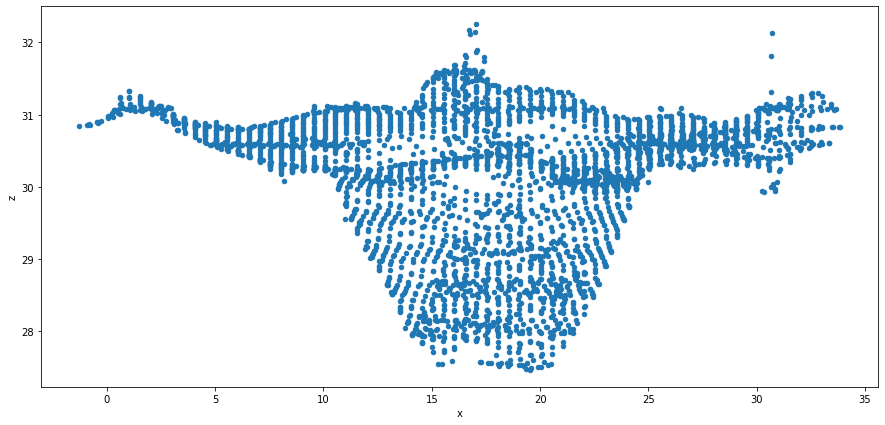

In [9]:
voxels_df.plot.scatter('x', 'z', figsize=(15,7))

<AxesSubplot:xlabel='y', ylabel='z'>

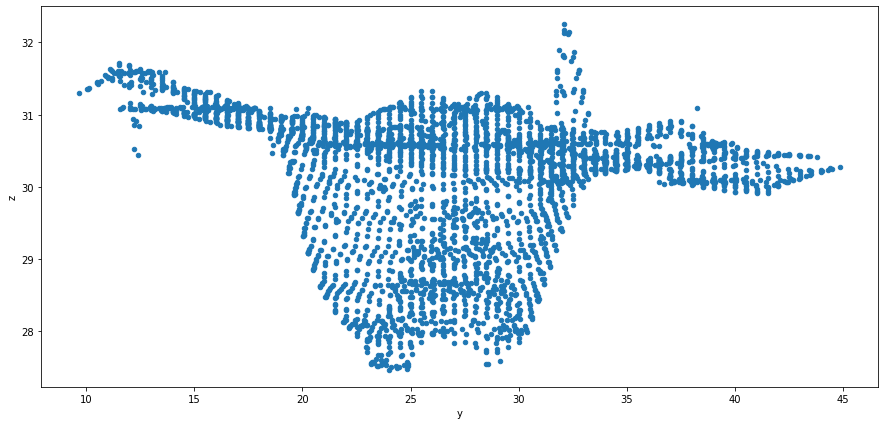

In [10]:
voxels_df.plot.scatter('y', 'z', figsize=(15,7))

In [7]:
floor, not_floor, plane_model = separate_floor(pcd, distance_threshold=0.21)

In [8]:
matrix = rotation_matrix(plane_model[:3])
floor.rotate(matrix)
not_floor.rotate(matrix)

PointCloud with 6463752 points.

In [16]:
floor.paint_uniform_color([1.0, 0, 0])
not_floor.paint_uniform_color([0, 0, 1.0])
axes = o3d.geometry.TriangleMesh.create_coordinate_frame(size=10)
o3d.visualization.draw_geometries([floor, not_floor, axes])

In [9]:
not_floor_points = np.asarray(not_floor.points)

peak_candidate_above = not_floor_points[:,2].max()
peak_candidate_below = not_floor_points[:,2].min()
floor_level =  floor.get_center()[2]

if peak_candidate_above - floor_level > floor_level - peak_candidate_below:
    not_floor_points = not_floor_points[not_floor_points[:,2] > floor_level]
    not_floor_points[:,2] -= not_floor_points[:,2].min()
else:
    not_floor_points = not_floor_points[not_floor_points[:,2] < floor.get_center()[2]]
    not_floor_points[:,2] *= -1
    not_floor_points[:,2] -= not_floor_points[:,2].min()

In [10]:
above_floor_pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(not_floor_points))
o3d.visualization.draw_geometries([above_floor_pcd])

![above floor](images/task2_above_floor.png)

In [11]:
labels = np.array(above_floor_pcd.cluster_dbscan(eps=0.025, min_points=10, print_progress=True))
max_label = labels.max()
colors = plt.get_cmap("tab20")(labels / (max_label 
if max_label > 0 else 1))
colors[labels < 0] = 0
above_floor_pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([above_floor_pcd])

In [12]:
stockpile_cluster = pd.Series(labels).mode()[0]

In [13]:
stockpile = np.asarray(above_floor_pcd.points)[labels == stockpile_cluster]
stockpile_pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(stockpile))
o3d.visualization.draw_geometries([stockpile_pcd])

In [14]:
stockpile_pcd

PointCloud with 3794869 points.

![stockpile](images/task2_stockpile.png)

Вычисление объема по вокселям:

In [15]:
VOXEL_SIZE = 0.05
stockpile_base_points = np.asarray(stockpile_pcd.points).copy()
stockpile_base_points[:,2] = 0
stockpile_base_pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(stockpile_base_points))
stockpile_base_voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(stockpile_base_pcd, voxel_size=VOXEL_SIZE)

In [16]:
stockpile_base_voxel_grid_centers = np.asarray([
    stockpile_base_voxel_grid.origin + voxel.grid_index*VOXEL_SIZE
    for voxel in stockpile_base_voxel_grid.get_voxels()
])[:,:2]

In [17]:
grids_bases = 0.5 * VOXEL_SIZE * np.array([
    [-1, 1], [1, 1],
    [-1, -1], [1, -1]
])

grids = grids_bases + stockpile_base_voxel_grid_centers[:,None]

In [25]:
grids.shape

(70785, 4, 2)

In [18]:
interpolation = griddata(stockpile[:,:2], stockpile[:,2], grids, method='linear')

In [114]:
interpolation = np.nan_to_num(interpolation, nan=0)

Считаем

In [19]:
(VOXEL_SIZE**2 * (interpolation[:,0] + interpolation[:,1] + interpolation[:,2] + interpolation[:,3])/4).sum()

222.80291516462404

Проверим порядок на глаз

In [20]:
pd.DataFrame(stockpile).describe()

,0,1,2
count,3.794869e+06,3.794869e+06,3.794869e+06
mean,1.695183e+01,2.592290e+01,1.275745e+00
std,4.119045e+00,3.460175e+00,8.373617e-01
min,7.508061e+00,1.818384e+01,4.748524e-03
25%,1.362295e+01,2.316318e+01,5.000573e-01
50%,1.709977e+01,2.604856e+01,1.291211e+00
75%,2.031016e+01,2.864784e+01,1.975250e+00
max,2.499990e+01,3.318682e+01,3.176836e+00


Основание приблизим чисто прямоугольником; внутри достаточно много углублений, так что все еще будем считать по формуле пирамиды, хоть склон и более резкий на этот раз

In [21]:
(25-7.5)*(33-18)*3*(1/3)

262.5

Работа с volpy:

<AxesSubplot:xlabel='x', ylabel='y'>

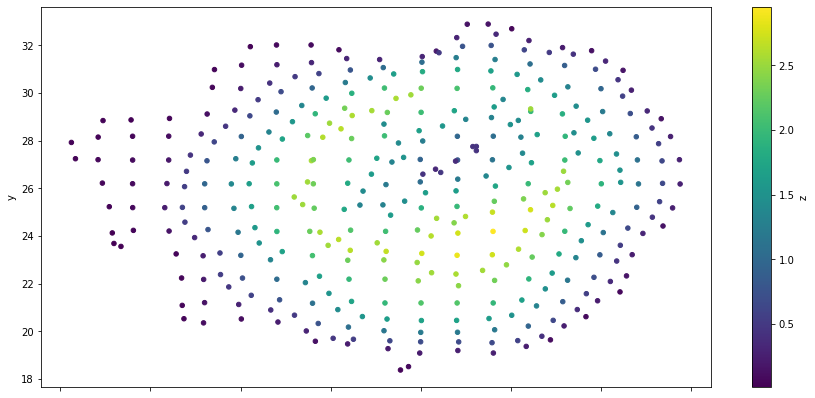

In [22]:
voxels_for_volpy = stockpile_pcd.voxel_down_sample(voxel_size=1)
voxels_for_volpy = np.asarray(voxels_for_volpy.points)
voxels_for_volpy = pd.DataFrame(voxels_for_volpy, columns=['x','y','z'])
voxels_for_volpy.plot.scatter('x', 'y', c='z', colormap='viridis', figsize=(15,7))

In [23]:
voxels_for_volpy.to_csv('voxels_for_volpy.csv', index=False)
survey = vp.load_survey('voxels_for_volpy.csv')
mesh = vp.terrain_mesh(survey.data)
mesh.get_volume()

Progress: |██████████████████████████████████████████████████| 100.0% Complete


219.650475798855

Истинный объем горки вероятно в районе 220  
Оценим погрешность

In [24]:
2*0.21 * len(stockpile_base_voxel_grid_centers)*VOXEL_SIZE**2

74.32635

Грубо верхнюю границу ошибки можно оценить как $\approx 30\%$

# Модель 3

In [4]:
FILEPATH = '3/DEM.xyz'
pcd = o3d.io.read_point_cloud(FILEPATH)
print(pcd)

PointCloud with 12959575 points.


In [26]:
axes = o3d.geometry.TriangleMesh.create_coordinate_frame(size=10)
o3d.visualization.draw_geometries([pcd])

![3D model with axes](images/task3_3D_with_axes.png)

<AxesSubplot:xlabel='x', ylabel='y'>

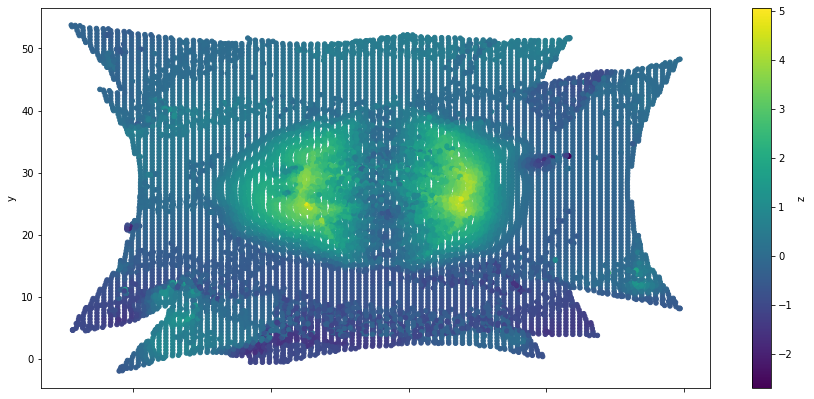

In [27]:
voxel_pcd = pcd.voxel_down_sample(voxel_size=0.5)
voxels = np.asarray(voxel_pcd.points)
voxels_df = pd.DataFrame(voxels, columns=['x','y','z'])
voxels_df.plot.scatter('x', 'y', c='z', colormap='viridis', figsize=(15,7))

<AxesSubplot:xlabel='x', ylabel='z'>

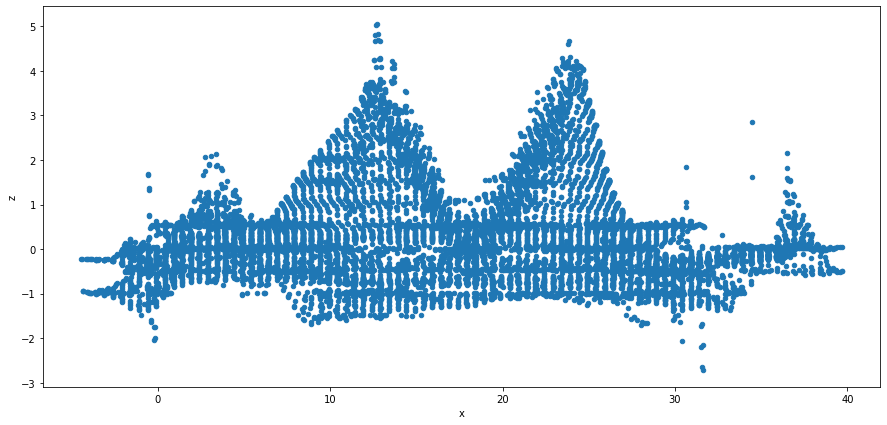

In [28]:
voxels_df.plot.scatter('x', 'z', figsize=(15,7))

<AxesSubplot:xlabel='y', ylabel='z'>

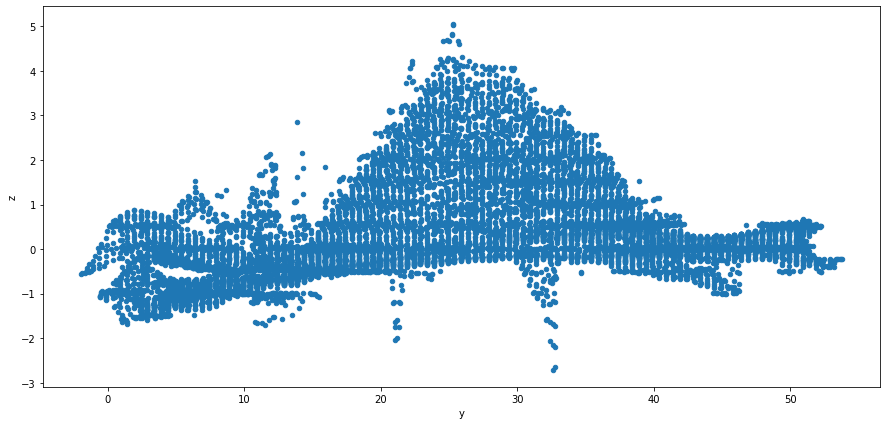

In [29]:
voxels_df.plot.scatter('y', 'z', figsize=(15,7))

Модель достаточно ровная, но все равно выделим плоскость (как минимум это сделает кластеризацию вообще возможной)

In [5]:
floor, not_floor, plane_model = separate_floor(pcd, distance_threshold=0.21)

In [6]:
matrix = rotation_matrix(plane_model[:3])
floor.rotate(matrix)
not_floor.rotate(matrix)

PointCloud with 7331031 points.

In [7]:
floor.paint_uniform_color([1.0, 0, 0])
not_floor.paint_uniform_color([0, 0, 1.0])
axes = o3d.geometry.TriangleMesh.create_coordinate_frame(size=10)
o3d.visualization.draw_geometries([floor, not_floor, axes])

In [8]:
not_floor_points = np.asarray(not_floor.points)

peak_candidate_above = not_floor_points[:,2].max()
peak_candidate_below = not_floor_points[:,2].min()
floor_level =  floor.get_center()[2]

if peak_candidate_above - floor_level > floor_level - peak_candidate_below:
    not_floor_points = not_floor_points[not_floor_points[:,2] > floor_level]
    not_floor_points[:,2] -= not_floor_points[:,2].min()
else:
    not_floor_points = not_floor_points[not_floor_points[:,2] < floor.get_center()[2]]
    not_floor_points[:,2] *= -1
    not_floor_points[:,2] -= not_floor_points[:,2].min()

In [9]:
above_floor_pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(not_floor_points))
o3d.visualization.draw_geometries([above_floor_pcd])

![above floor](images/task3_above_floor.png)

In [27]:
labels = np.array(above_floor_pcd.cluster_dbscan(eps=0.05, min_points=10, print_progress=True))
max_label = labels.max()
colors = plt.get_cmap("tab20")(labels / (max_label 
if max_label > 0 else 1))
colors[labels < 0] = 0
above_floor_pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([above_floor_pcd])

In [28]:
stockpile_cluster = pd.Series(labels).mode()[0]

In [29]:
stockpile = np.asarray(above_floor_pcd.points)[labels == stockpile_cluster]
stockpile_pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(stockpile))
o3d.visualization.draw_geometries([stockpile_pcd])

In [14]:
stockpile_pcd

PointCloud with 3794869 points.

![stockpile](images/task3_stockpile.png)

Вычисление объема по вокселям:

In [30]:
VOXEL_SIZE = 0.05
stockpile_base_points = np.asarray(stockpile_pcd.points).copy()
stockpile_base_points[:,2] = 0
stockpile_base_pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(stockpile_base_points))
stockpile_base_voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(stockpile_base_pcd, voxel_size=VOXEL_SIZE)

In [31]:
stockpile_base_voxel_grid_centers = np.asarray([
    stockpile_base_voxel_grid.origin + voxel.grid_index*VOXEL_SIZE
    for voxel in stockpile_base_voxel_grid.get_voxels()
])[:,:2]

In [32]:
grids_bases = 0.5 * VOXEL_SIZE * np.array([
    [-1, 1], [1, 1],
    [-1, -1], [1, -1]
])

grids = grids_bases + stockpile_base_voxel_grid_centers[:,None]

In [33]:
grids.shape

(217980, 4, 2)

In [34]:
interpolation = griddata(stockpile[:,:2], stockpile[:,2], grids, method='linear')

In [35]:
interpolation = np.nan_to_num(interpolation, nan=0)

Считаем

In [36]:
(VOXEL_SIZE**2 * (interpolation[:,0] + interpolation[:,1] + interpolation[:,2] + interpolation[:,3])/4).sum()

645.8104309432068

Проверим порядок на глаз

In [38]:
pd.DataFrame(stockpile).describe()

,0,1,2
count,3.714614e+06,3.714614e+06,3.714614e+06
mean,1.575422e+01,2.763825e+01,1.206123e+00
std,7.527809e+00,6.376827e+00,1.031262e+00
min,-5.930524e-01,1.422170e+01,3.895296e-03
25%,1.000343e+01,2.253405e+01,2.693814e-01
50%,1.597754e+01,2.786035e+01,9.892709e-01
75%,2.210881e+01,3.285141e+01,1.929259e+00
max,2.899858e+01,4.062678e+01,5.148425e+00


Как минимум треть пирамиды, которую можно попытаться увидеть в этой горке, отсутствует, так что

In [41]:
(29-0)*(40-14)*5*(1/3)*(2/3)

837.7777777777776

Работа с volpy:

<AxesSubplot:xlabel='x', ylabel='y'>

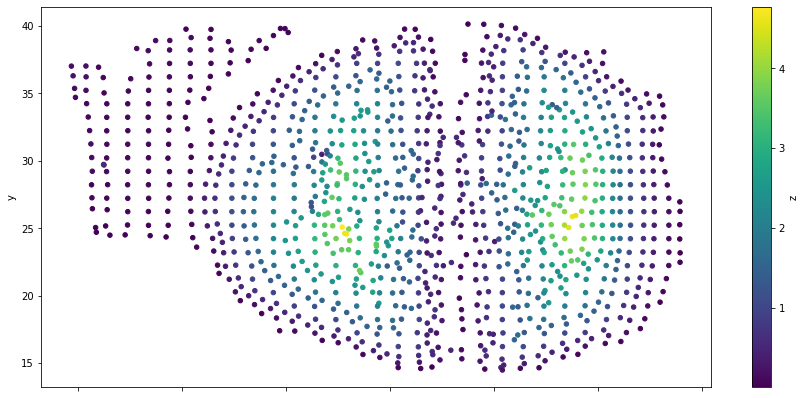

In [42]:
voxels_for_volpy = stockpile_pcd.voxel_down_sample(voxel_size=1)
voxels_for_volpy = np.asarray(voxels_for_volpy.points)
voxels_for_volpy = pd.DataFrame(voxels_for_volpy, columns=['x','y','z'])
voxels_for_volpy.plot.scatter('x', 'y', c='z', colormap='viridis', figsize=(15,7))

In [43]:
voxels_for_volpy.to_csv('voxels_for_volpy.csv', index=False)
survey = vp.load_survey('voxels_for_volpy.csv')
mesh = vp.terrain_mesh(survey.data)
mesh.get_volume()

Progress: |██████████████████████████████████████████████████| 100.0% Complete


649.363146329097

Истинный объем горки вероятно в районе 220  
Оценим погрешность

In [48]:
2*0.21 * len(stockpile_base_voxel_grid_centers)*VOXEL_SIZE**2

228.87900000000002

Грубо верхнюю границу ошибки можно оценить как $\approx 30\%$